In [1]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = T.Compose([
    T.Resize((32, 32)),  # Resize images to (32, 32)
])

In [4]:
dataset = []
for image in os.listdir('./dogs-cats-mini'):
    dataset.append((transform(read_image(f'./dogs-cats-mini/{image}').float()), 1 if 'cat' in image else 0))

/home/toddi/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
train_set, val_test_set = train_test_split(dataset, test_size=0.3)
val_set, test_set = train_test_split(val_test_set, test_size=0.5)

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [ ]:
# # Creating a CNN class
# class ConvNeuralNet(nn.Module):
# 	#  Determine what layers and their order in CNN object 
#     def __init__(self):
#         super(ConvNeuralNet, self).__init__()
#         self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
#         self.relu1 = nn.ReLU()
#         self.batch_norm1 = nn.BatchNorm2d(32)
#         self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
#         self.relu2 = nn.ReLU()
#         self.batch_norm2 = nn.BatchNorm2d(32)
#         self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
#         self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
#         self.relu3 = nn.ReLU()
#         self.batch_norm3 = nn.BatchNorm2d(64)
#         self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
#         self.relu4 = nn.ReLU()
#         self.batch_norm4 = nn.BatchNorm2d(64)
#         self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
#         self.fc1 = nn.Linear(1600, 800)
#         self.relu5 = nn.ReLU()
#         self.batch_norm5 = nn.BatchNorm1d(800)
#         self.fc2 = nn.Linear(800, 128)
#         self.relu6 = nn.ReLU()
#         self.batch_norm6 = nn.BatchNorm1d(128)
#         self.fc3 = nn.Linear(128, 1)

    
#     # Progresses data across layers    
#     def forward(self, x):
#         out = self.conv_layer1(x)
#         out = self.relu1(out)
#         out = self.batch_norm1(out)
#         out = self.conv_layer2(out)
#         out = self.relu2(out)
#         out = self.batch_norm2(out)
#         out = self.max_pool1(out)
#         out = self.conv_layer3(out)
#         out = self.relu3(out)
#         out = self.batch_norm3(out)
#         out = self.conv_layer4(out)
#         out = self.relu4(out)
#         out = self.batch_norm4(out)
#         out = self.max_pool2(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc1(out)
#         out = self.relu5(out)
#         out = self.batch_norm5(out)
#         out = self.fc2(out)
#         out = self.relu6(out)
#         out = self.batch_norm6(out)
#         out = self.fc3(out)

#         return out
class ConvNeuralNet(nn.Module):
    # Determine what layers and their order in CNN object
    def __init__(self):
        super(ConvNeuralNet, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
        )

        self.linear = nn.Sequential(
            nn.Linear(1600, 800),
            nn.ReLU(),
            nn.BatchNorm1d(800),
            nn.Dropout(0.2),
            nn.Linear(800, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 1),
        )

    # Progresses data across layers
    def forward(self, x):
        out = self.convs(x)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

SyntaxError: invalid syntax. Perhaps you forgot a comma? (430360279.py, line 70)

In [ ]:
model = ConvNeuralNet().to(device)

# Set Loss function with criterion
criterion = nn.BCEWithLogitsLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)  

In [ ]:
val_loss, train_loss = [], []
epochs = 20
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(epochs):
    t_loss = 0.0
    v_loss = 0.0
    model.train()
    for images, labels in train_loader:

        outputs = model(images)        
        loss = criterion(outputs, labels.unsqueeze(1).float())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # stats
        t_loss += loss.item()
    train_loss.append(t_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            v_loss += loss.item()
    val_loss.append(v_loss / len(val_loader))
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

: 

: 

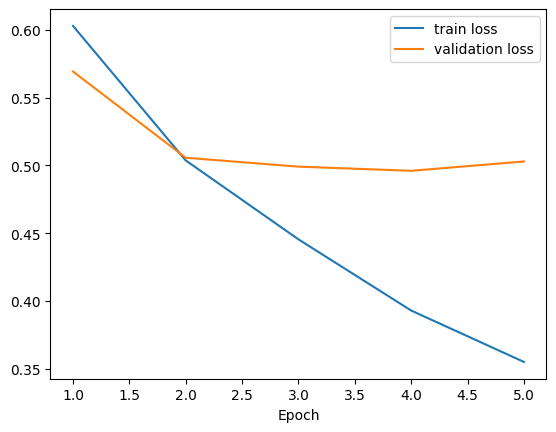

In [ ]:
plt.plot(torch.arange(1, epochs+1, 1), train_loss, label='train loss')
plt.plot(torch.arange(1, epochs+1, 1), val_loss, label='validation loss')
plt.xlabel('Epoch')
plt.legend();

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()
    print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')


Accuracy of the network on the 3750 test images: 77.28%


In [ ]:
for images, labels in test_set:
    outputs = model(images)
    predicted = torch.round(torch.sigmoid(outputs))
    cm = confusion_matrix(labels, predicted)
    dips = ConfusionMatrixDisplay(cm, display_labels=['Cat', 'Dog'])
    dips.plot()

NameError: name 'test_set' is not defined